# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

In [2]:
# important note to add superheroes.txt before running the below cells

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [3]:
with open('superheroes.txt', 'r') as f:  # opening the downloaded txt file, then read the file
  data = f.read()   # store the content of the file in data

data[:100]    # dispalying the first 100 names that are stored in the data file

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [4]:
# creating a charecter level language model
# we have to create a numeric representation of the charecters to feed the training model this is called tokenizing
import tensorflow as tf
tf.__version__

'2.7.0'

In [5]:
# this tokenizer converts charecters to numbers 
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [6]:
tokenizer.fit_on_texts(data)   # fiting the tokenizer to the txt data

In [7]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)   # so when we get char a it assigns number 2

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [8]:
names = data.splitlines()  # spliting data at the new line charecter
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [9]:
# converting 3rd(starlight) name to the number
tokenizer.texts_to_sequences(names[2])

[[10], [9], [2], [4], [11], [7], [17], [13], [9], [1]]

In [10]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]  # we have to take 1 charecter at a time 
# we are using [0][0] to squeeze the dimensions we can see that 
# in previous example in the output list each element is also a list 

In [11]:
name_to_seq(names[2])

[10, 9, 2, 4, 11, 7, 17, 13, 9, 1]

In [12]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!=0])

In [13]:
seq_to_name([10, 9, 2, 4, 11, 7, 17, 13, 9, 1])

'starlight\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [14]:
sequences = []
for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2, len(seq) + 1)]

In [15]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [16]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [17]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='pre', maxlen=max_len)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [18]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [19]:
x,y = padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)
print(x[2],y[2])

(88279, 32) (88279,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 25 16 12] 20


In [20]:
from sklearn.model_selection import  train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [22]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


## Task 6: Creating the Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Bidirectional, Dense

model = Sequential([Embedding(num_chars, 8, input_length=max_len-1),
                    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars, activation='softmax')]
                    )

model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 8)             232       
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2624      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 29)                957       
                                                                 
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
____________________________________________________

## Task 7: Training the Model

In [24]:
h= model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, verbose=2,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/50
2070/2070 - 54s - loss: 2.7775 - accuracy: 0.1822 - val_loss: 2.6291 - val_accuracy: 0.2052 - 54s/epoch - 26ms/step
Epoch 2/50
2070/2070 - 19s - loss: 2.5733 - accuracy: 0.2269 - val_loss: 2.5378 - val_accuracy: 0.2364 - 19s/epoch - 9ms/step
Epoch 3/50
2070/2070 - 21s - loss: 2.4910 - accuracy: 0.2512 - val_loss: 2.4731 - val_accuracy: 0.2520 - 21s/epoch - 10ms/step
Epoch 4/50
2070/2070 - 21s - loss: 2.4350 - accuracy: 0.2662 - val_loss: 2.4295 - val_accuracy: 0.2661 - 21s/epoch - 10ms/step
Epoch 5/50
2070/2070 - 21s - loss: 2.3939 - accuracy: 0.2780 - val_loss: 2.4020 - val_accuracy: 0.2728 - 21s/epoch - 10ms/step
Epoch 6/50
2070/2070 - 19s - loss: 2.3602 - accuracy: 0.2885 - val_loss: 2.3733 - val_accuracy: 0.2876 - 19s/epoch - 9ms/step
Epoch 7/50
2070/2070 - 21s - loss: 2.3320 - accuracy: 0.2979 - val_loss: 2.3507 - val_accuracy: 0.2899 - 21s/epoch - 10ms/step
Epoch 8/50
2070/2070 - 19s - loss: 2.3050 - accuracy: 0.3035 - val_loss: 2.3404 - val_accuracy: 0.2969 - 19s/epoc

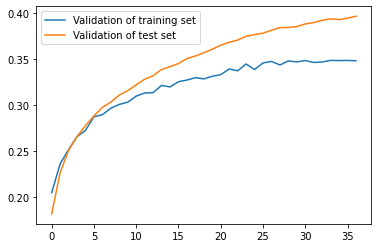

In [25]:
from matplotlib import pyplot as plt 
epochs_ran = len(h.history['loss'])

plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation of training set')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Validation of test set')
plt.legend()
plt.show()

## Task 8: Generate Names!

In [26]:
def generated_names(seed):
  for i in range(0, 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre', maxlen=max_len-1, truncating='pre')

    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char
    
    if pred_char == '\t':
      break
    print(seed)

In [38]:
generated_names('e')

el
ele
eles
elest
elestr
elestro
